## Experiment Overview

This experiment aims to show the necessity of QLoRA for fine-tuning large language models on constrained hardware. We will compare model size (3B, 8B, 70B) against fine-tuning methods (Full, LoRA, QLoRA).

## Environment Setup

We will configure the environment to meet the requirements specified in the experiment plan. This includes installing necessary libraries, downloading the LLaMA models from Hugging Face, and preparing the fine-tuning dataset.

In [ ]:
import os

scratch_path = "/scratch/tkavuru/huggingface_cache"

os.makedirs(scratch_path, exist_ok=True)

os.environ["HF_HOME"] = scratch_path

import torch
from transformers import AutoModelForCausalLM

Cache redirected to: /scratch/tkavuru/huggingface_cache


/home/tkavuru/.conda/envs/vllm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
import gc
import time
import pandas as pd
import os
import psutil
import warnings
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

GPU: NVIDIA A100 80GB PCIe
VRAM: 79.14 GB


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_MAP = {
    "3B": "meta-llama/Llama-3.2-3B-Instruct",
    "8B": "meta-llama/Llama-3.1-8B-Instruct",
    "70B": "meta-llama/Llama-3.1-70B-Instruct"
}

def get_vram_gb(): 
    try: return torch.cuda.max_memory_allocated(0) / 1024**3
    except: return 0

def run_track(track_id, model_size, method, max_steps=200):
    torch.cuda.empty_cache()
    gc.collect()
    try:
        torch.cuda.reset_peak_memory_stats(0)
    except:
        pass

    print(f"\n TRACK {track_id}: {model_size} | {method}")

    model_id = MODEL_MAP[model_size]

    try:
        print(f"Loading {model_id}...")
        bnb_config = None
        if method == "QLoRA":
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True, bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_use_double_quant=True
            )

        model = AutoModelForCausalLM.from_pretrained(
            model_id, quantization_config=bnb_config,
            torch_dtype=torch.bfloat16, device_map={"": 0}, use_cache=False
        )

        if method in ["QLoRA", "LoRA"]:
            peft_config = LoraConfig(
                r=16, lora_alpha=32, target_modules=["q_proj", "v_proj"], 
                lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
            )
            if method == "QLoRA":
                model = prepare_model_for_kbit_training(model)
            model = get_peft_model(model, peft_config)
            model.print_trainable_parameters()

        elif method == "Full":
            for param in model.parameters():
                param.requires_grad = True

            model.gradient_checkpointing_enable()

            if hasattr(model, "enable_input_require_grads"):
                model.enable_input_require_grads()
            else:
                def make_inputs_require_grad(module, input, output):
                    output.requires_grad_(True)
                model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

            trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Full FT Trainable Params: {trainable:,}")

        tokenizer = AutoTokenizer.from_pretrained(model_id)
        tokenizer.pad_token = tokenizer.eos_token

        raw_ds = load_dataset("yahma/alpaca-cleaned", split="train")
        def format_prompt(sample):
            ins, inp, out = sample['instruction'], sample['input'], sample['output']
            text = f"### Instruction:\n{ins}\n\n### Input:\n{inp}\n\n### Response:\n{out}" if inp else f"### Instruction:\n{ins}\n\n### Response:\n{out}"
            return {"text": text + tokenizer.eos_token}
        ds_formatted = raw_ds.map(format_prompt)

        ds_filtered = ds_formatted.filter(lambda x: len(tokenizer(x['text'])['input_ids']) <= 2048)
        ds_final = ds_filtered.select(range(3000)).train_test_split(test_size=0.1)

        def collate_fn(batch):
            texts = [item['text'] for item in batch]
            return tokenizer(texts, padding=True, return_tensors="pt").to(0)

        train_loader = torch.utils.data.DataLoader(ds_final["train"], batch_size=1, shuffle=True, collate_fn=collate_fn)
        val_loader = torch.utils.data.DataLoader(ds_final["test"], batch_size=1, shuffle=False, collate_fn=collate_fn)

        learning_rate = 2e-4 if "LoRA" in method else 2e-5
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

        print("Calculating Initial Loss...")
        history = []
        model.eval()

        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for vbatch in val_loader:
                vout = model(**vbatch, labels=vbatch["input_ids"])
                val_loss += vout.loss.item()
                val_batches += 1
        val_loss = val_loss / max(1, val_batches)

        tbatch = next(iter(train_loader))
        train_out = model(**tbatch, labels=tbatch["input_ids"])
        train_loss_init = train_out.loss.item()

        print(f"Initial Train Loss: {train_loss_init:.4f}")
        print(f"Initial Validation Loss: {val_loss:.4f}")
        history.append({'track_id': track_id, 'step': 0, 'loss': train_loss_init, 'type': 'Train'})
        history.append({'track_id': track_id, 'step': 0, 'loss': val_loss, 'type': 'Validation'})

        model.train()

        print("Training...")
        start_time = time.time()

        step = 0
        accumulation_steps = 4
        optimizer.zero_grad()

        pbar = tqdm(total=max_steps, desc="Steps", leave=False)
        data_iter = iter(train_loader)

        while step < max_steps:
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)

            outputs = model(**batch, labels=batch["input_ids"])
            loss = outputs.loss / accumulation_steps
            loss.backward()

            current_step_count = step + 1

            if current_step_count % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

                if current_step_count % 20 == 0:
                    curr_loss = loss.item() * accumulation_steps
                    print(f"Step {current_step_count}: Train Loss = {curr_loss:.4f}")

                    model.eval()
                    val_loss = 0
                    val_batches = 0
                    with torch.no_grad():
                        for vbatch in val_loader:
                            vout = model(**vbatch, labels=vbatch["input_ids"])
                            val_loss += vout.loss.item()
                            val_batches += 1
                    val_loss = val_loss / max(1, val_batches)
                    model.train()

                    print(f"Step {current_step_count}: Validation Loss = {val_loss:.4f}")
                    history.append({'track_id': track_id, 'step': current_step_count, 'loss': curr_loss, 'type': 'Train'})
                    history.append({'track_id': track_id, 'step': current_step_count, 'loss': val_loss, 'type': 'Validation'})

                pbar.update(1)
            step += 1

        pbar.close()
        duration = time.time() - start_time
        peak_vram = get_vram_gb()

        del model, tokenizer, optimizer, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

        return (
            {"track_id": track_id, "model_size": model_size, "method": method,
             "status": "Success", "peak_vram_gb": peak_vram, "time": duration},
            history
        )

    except RuntimeError as e:
        print(f"Runtime Error: {e}")
        raise e 

all_results = []
all_history = []

import os
import pandas as pd

def save_result(result_tuple):
    summary, history = result_tuple

    if os.path.exists("partial_results.csv"):
        existing_results = pd.read_csv("partial_results.csv")
        all_results_df = pd.concat([existing_results, pd.DataFrame([summary])], ignore_index=True)
    else:
        all_results_df = pd.DataFrame([summary])

    if os.path.exists("partial_history.csv"):
        existing_history = pd.read_csv("partial_history.csv")
        all_history_df = pd.concat([existing_history, pd.DataFrame(history)], ignore_index=True)
    else:
        all_history_df = pd.DataFrame(history)

    all_results_df.to_csv("partial_results.csv", index=False)
    all_history_df.to_csv("partial_history.csv", index=False)

    print(f"Results and history appended and saved.")

In [ ]:
# Initial Check
print("3B QLoRA (20 Steps)...")
res, hist = run_track("TEST", "3B", "QLoRA", max_steps=20)

if res['status'] == 'Success':
    print(f"PASSED VRAM: {res['peak_vram_gb']:.2f} GB")
else:
    print("FAILED")

`torch_dtype` is deprecated! Use `dtype` instead!


3B QLoRA (20 Steps)...

TRACK TEST: 3B | QLoRA
Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


trainable params: 4,587,520 || all params: 3,217,337,344 || trainable%: 0.1426
Calculating Initial Loss...
Initial Train Loss: 2.0581
Initial Validation Loss: 2.0106
Training...


Steps:  20%|██        | 4/20 [00:03<00:14,  1.10it/s]

Step 20: Train Loss = 2.1798


Step 20: Validation Loss = 1.7925


PASSED VRAM: 4.22 GB


In [ ]:
# [CELL 3] SAFE TRACKS
safe_tracks = [
    ("T3", "70B", "QLoRA"),
    ("T6", "8B",  "QLoRA"),
    ("T5", "8B",  "LoRA"),
    ("T9", "3B",  "QLoRA"),
    ("T8", "3B",  "LoRA"),
    ("T7", "3B",  "Full"),
]

print("Starting Experiments...")
pbar = tqdm(safe_tracks, desc="Overall Progress")

for track_id, size, method in pbar:
    pbar.set_description(f"Running {size} {method}")
    save_result(run_track(track_id, size, method))

print("Saved.")

Starting Experiments...


Running 70B QLoRA:   0%|          | 0/6 [00:00<?, ?it/s]


TRACK T3: 70B | QLoRA
Loading meta-llama/Llama-3.1-70B-Instruct...


Loading checkpoint shards: 100%|██████████| 30/30 [06:44<00:00, 13.49s/it]


trainable params: 32,768,000 || all params: 70,586,474,496 || trainable%: 0.0464
Calculating Initial Loss...
Initial Train Loss: 2.8044
Initial Validation Loss: 1.7972
Training...


Step 20: Train Loss = 1.5795


Step 20: Validation Loss = 1.5168


Step 40: Train Loss = 0.8549


Step 40: Validation Loss = 1.3037


Step 60: Train Loss = 2.0339


Step 60: Validation Loss = 1.2755


Step 80: Train Loss = 1.1079


Step 80: Validation Loss = 1.2621


Step 100: Train Loss = 1.3187


Step 100: Validation Loss = 1.2479


Step 120: Train Loss = 1.7375


Step 120: Validation Loss = 1.2371


Step 140: Train Loss = 2.1123


Step 140: Validation Loss = 1.2321


Step 160: Train Loss = 2.1213


Step 160: Validation Loss = 1.2200


Step 180: Train Loss = 1.3876


Step 180: Validation Loss = 1.2135


Step 200: Train Loss = 0.8503


Step 200: Validation Loss = 1.2132


Running 8B QLoRA:  17%|█▋        | 1/6 [38:22<3:11:53, 2302.76s/it] 

Saved.

TRACK T6: 8B | QLoRA
Loading meta-llama/Llama-3.1-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 4/4 [00:40<00:00, 10.25s/it]


trainable params: 6,815,744 || all params: 8,037,076,992 || trainable%: 0.0848
Calculating Initial Loss...
Initial Train Loss: 1.8620
Initial Validation Loss: 1.9013
Training...


Step 20: Train Loss = 2.1352


Step 20: Validation Loss = 1.6833


Step 40: Train Loss = 2.5815


Step 40: Validation Loss = 1.4385


Step 60: Train Loss = 1.2922


Step 60: Validation Loss = 1.3640


Step 80: Train Loss = 1.8013


Step 80: Validation Loss = 1.3485


Step 100: Train Loss = 0.6469


Step 100: Validation Loss = 1.3281


Step 120: Train Loss = 0.9727


Step 120: Validation Loss = 1.3125


Step 140: Train Loss = 0.7149


Step 140: Validation Loss = 1.3075


Step 160: Train Loss = 1.2566


Step 160: Validation Loss = 1.2974


Step 180: Train Loss = 1.3761


Step 180: Validation Loss = 1.2893


Step 200: Train Loss = 0.9230


Step 200: Validation Loss = 1.2828


Running 8B LoRA:  33%|███▎      | 2/6 [45:23<1:19:42, 1195.66s/it] 

Saved.

TRACK T5: 8B | LoRA
Loading meta-llama/Llama-3.1-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 4/4 [00:33<00:00,  8.50s/it]


trainable params: 6,815,744 || all params: 8,037,076,992 || trainable%: 0.0848
Calculating Initial Loss...
Initial Train Loss: 2.5997
Initial Validation Loss: 1.9456
Training...


Step 20: Train Loss = 2.9331


Step 20: Validation Loss = 1.7205


Step 40: Train Loss = 1.4446


Step 40: Validation Loss = 1.4694


Step 60: Train Loss = 1.2480


Step 60: Validation Loss = 1.3727


Step 80: Train Loss = 1.3690


Step 80: Validation Loss = 1.3455


Step 100: Train Loss = 1.2805


Step 100: Validation Loss = 1.3348


Step 120: Train Loss = 1.2814


Step 120: Validation Loss = 1.3199


Step 140: Train Loss = 1.4750


Step 140: Validation Loss = 1.3084


Step 160: Train Loss = 1.3680


Step 160: Validation Loss = 1.3007


Step 180: Train Loss = 1.0406


Step 180: Validation Loss = 1.2892


Step 200: Train Loss = 1.2955


Step 200: Validation Loss = 1.2785


Running 3B QLoRA:  50%|█████     | 3/6 [48:07<36:13, 724.43s/it]  

Saved.

TRACK T9: 3B | QLoRA
Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.50s/it]


trainable params: 4,587,520 || all params: 3,217,337,344 || trainable%: 0.1426
Calculating Initial Loss...
Initial Train Loss: 1.2917
Initial Validation Loss: 2.0271
Training...


Step 20: Train Loss = 1.9177


Step 20: Validation Loss = 1.8038


Step 40: Train Loss = 1.2470


Step 40: Validation Loss = 1.5610


Step 60: Train Loss = 1.7410


Step 60: Validation Loss = 1.4858


Step 80: Train Loss = 2.0603


Step 80: Validation Loss = 1.4497


Step 100: Train Loss = 1.4176


Step 100: Validation Loss = 1.4356


Step 120: Train Loss = 1.3496


Step 120: Validation Loss = 1.4299


Step 140: Train Loss = 2.5549


Step 140: Validation Loss = 1.4218


Step 160: Train Loss = 1.5772


Step 160: Validation Loss = 1.4197


Step 180: Train Loss = 1.4998


Step 180: Validation Loss = 1.4131


Step 200: Train Loss = 1.1515


Step 200: Validation Loss = 1.4092


Running 3B LoRA:  67%|██████▋   | 4/6 [53:11<18:37, 558.70s/it] 

Saved.

TRACK T8: 3B | LoRA
Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.77s/it]


trainable params: 4,587,520 || all params: 3,217,337,344 || trainable%: 0.1426
Calculating Initial Loss...
Initial Train Loss: 1.4865
Initial Validation Loss: 1.9536
Training...


Step 20: Train Loss = 1.4728


Step 20: Validation Loss = 1.7599


Step 40: Train Loss = 2.0032


Step 40: Validation Loss = 1.5463


Step 60: Train Loss = 1.8181


Step 60: Validation Loss = 1.4833


Step 80: Train Loss = 1.5211


Step 80: Validation Loss = 1.4532


Step 100: Train Loss = 1.5677


Step 100: Validation Loss = 1.4360


Step 120: Train Loss = 1.3986


Step 120: Validation Loss = 1.4254


Step 140: Train Loss = 2.0444


Step 140: Validation Loss = 1.4160


Step 160: Train Loss = 1.3465


Step 160: Validation Loss = 1.4131


Step 180: Train Loss = 0.9908


Step 180: Validation Loss = 1.4062


Step 200: Train Loss = 1.1177


Step 200: Validation Loss = 1.4010


Running 3B Full:  83%|████████▎ | 5/6 [55:08<06:39, 399.50s/it]

Saved.

TRACK T7: 3B | Full
Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.09s/it]


Unfreezing all parameters for Full FT...
Full FT Trainable Params: 3,212,749,824
Calculating Initial Loss...
Initial Train Loss: 1.5133
Initial Validation Loss: 2.0031
Training...


Step 20: Train Loss = 1.1673


Step 20: Validation Loss = 1.4455


Step 40: Train Loss = 1.2413


Step 40: Validation Loss = 1.3953


Step 60: Train Loss = 1.0113


Step 60: Validation Loss = 1.3570


Step 80: Train Loss = 1.7869


Step 80: Validation Loss = 1.3188


Step 100: Train Loss = 1.3562


Step 100: Validation Loss = 1.2956


Step 120: Train Loss = 1.6643


Step 120: Validation Loss = 1.2825


Step 140: Train Loss = 1.0495


Step 140: Validation Loss = 1.2765


Step 160: Train Loss = 1.2572


Step 160: Validation Loss = 1.2726


Step 180: Train Loss = 1.5476


Step 180: Validation Loss = 1.2666


Step 200: Train Loss = 2.0940


Step 200: Validation Loss = 1.2619


Running 3B Full: 100%|██████████| 6/6 [56:50<00:00, 568.49s/it]

Saved.
Safe tracks saved.


In [ ]:
# 70B Standard LoRA (Expected OOM-Load)
save_result(run_track("T2", "70B", "LoRA"))

ATTEMPTING CRASH TRACKS...

TRACK T2: 70B | LoRA
Loading meta-llama/Llama-3.1-70B-Instruct...


Loading checkpoint shards:  57%|█████▋    | 17/30 [03:02<02:19, 10.76s/it]


Runtime Error: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 294.06 MiB is free. Including non-PyTorch memory, this process has 78.66 GiB memory in use. Of the allocated memory 78.09 GiB is allocated by PyTorch, and 65.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 294.06 MiB is free. Including non-PyTorch memory, this process has 78.66 GiB memory in use. Of the allocated memory 78.09 GiB is allocated by PyTorch, and 65.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# this ended up working
save_result(run_track("T4", "8B", "Full"))


TRACK T4: 8B | Full
Loading meta-llama/Llama-3.1-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Unfreezing all parameters for Full FT...
Full FT Trainable Params: 8,030,261,248
Calculating Initial Loss...
Initial Train Loss: 2.4399
Initial Validation Loss: 1.9270
Training...


Steps:   2%|▏         | 4/200 [00:02<02:24,  1.36it/s]

Step 20: Train Loss = 1.2588


Steps:   2%|▎         | 5/200 [00:12<12:36,  3.88s/it]

Step 20: Validation Loss = 1.3241


Steps:   4%|▍         | 9/200 [00:15<04:28,  1.41s/it]

Step 40: Train Loss = 1.6341


Steps:   5%|▌         | 10/200 [00:25<12:25,  3.92s/it]

Step 40: Validation Loss = 1.3126


Steps:   7%|▋         | 14/200 [00:27<04:33,  1.47s/it]

Step 60: Train Loss = 1.3376


Steps:   8%|▊         | 15/200 [00:37<11:58,  3.89s/it]

Step 60: Validation Loss = 1.2828


Steps:  10%|▉         | 19/200 [00:40<04:28,  1.49s/it]

Step 80: Train Loss = 1.1339


Steps:  10%|█         | 20/200 [00:49<11:41,  3.90s/it]

Step 80: Validation Loss = 1.2765


Steps:  12%|█▏        | 24/200 [00:52<04:24,  1.50s/it]

Step 100: Train Loss = 1.6349


Steps:  12%|█▎        | 25/200 [01:02<11:21,  3.89s/it]

Step 100: Validation Loss = 1.2496


Steps:  14%|█▍        | 29/200 [01:05<04:26,  1.56s/it]

Step 120: Train Loss = 1.2625


Steps:  15%|█▌        | 30/200 [01:15<11:14,  3.97s/it]

Step 120: Validation Loss = 1.2595


Steps:  17%|█▋        | 34/200 [01:18<04:16,  1.54s/it]

Step 140: Train Loss = 1.1753


Steps:  18%|█▊        | 35/200 [01:27<10:47,  3.92s/it]

Step 140: Validation Loss = 1.2542


Steps:  20%|█▉        | 39/200 [01:30<04:01,  1.50s/it]

Step 160: Train Loss = 1.4675


Steps:  20%|██        | 40/200 [01:40<10:36,  3.98s/it]

Step 160: Validation Loss = 1.2501


Steps:  22%|██▏       | 44/200 [01:43<04:00,  1.54s/it]

Step 180: Train Loss = 1.0595


Steps:  22%|██▎       | 45/200 [01:52<10:06,  3.91s/it]

Step 180: Validation Loss = 1.2405


Steps:  24%|██▍       | 49/200 [01:55<03:47,  1.51s/it]

Step 200: Train Loss = 1.1990


Step 200: Validation Loss = 1.2378


Results and history appended and saved.


In [ ]:
# 70B Full (Expected OOM-Load)
save_result(run_track("T1", "70B", "Full"))


TRACK T1: 70B | Full
Loading meta-llama/Llama-3.1-70B-Instruct...


Loading checkpoint shards:  57%|█████▋    | 17/30 [00:58<00:44,  3.41s/it]


Runtime Error: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 54.06 MiB is free. Including non-PyTorch memory, this process has 78.90 GiB memory in use. Of the allocated memory 78.33 GiB is allocated by PyTorch, and 60.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 54.06 MiB is free. Including non-PyTorch memory, this process has 78.90 GiB memory in use. Of the allocated memory 78.33 GiB is allocated by PyTorch, and 60.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

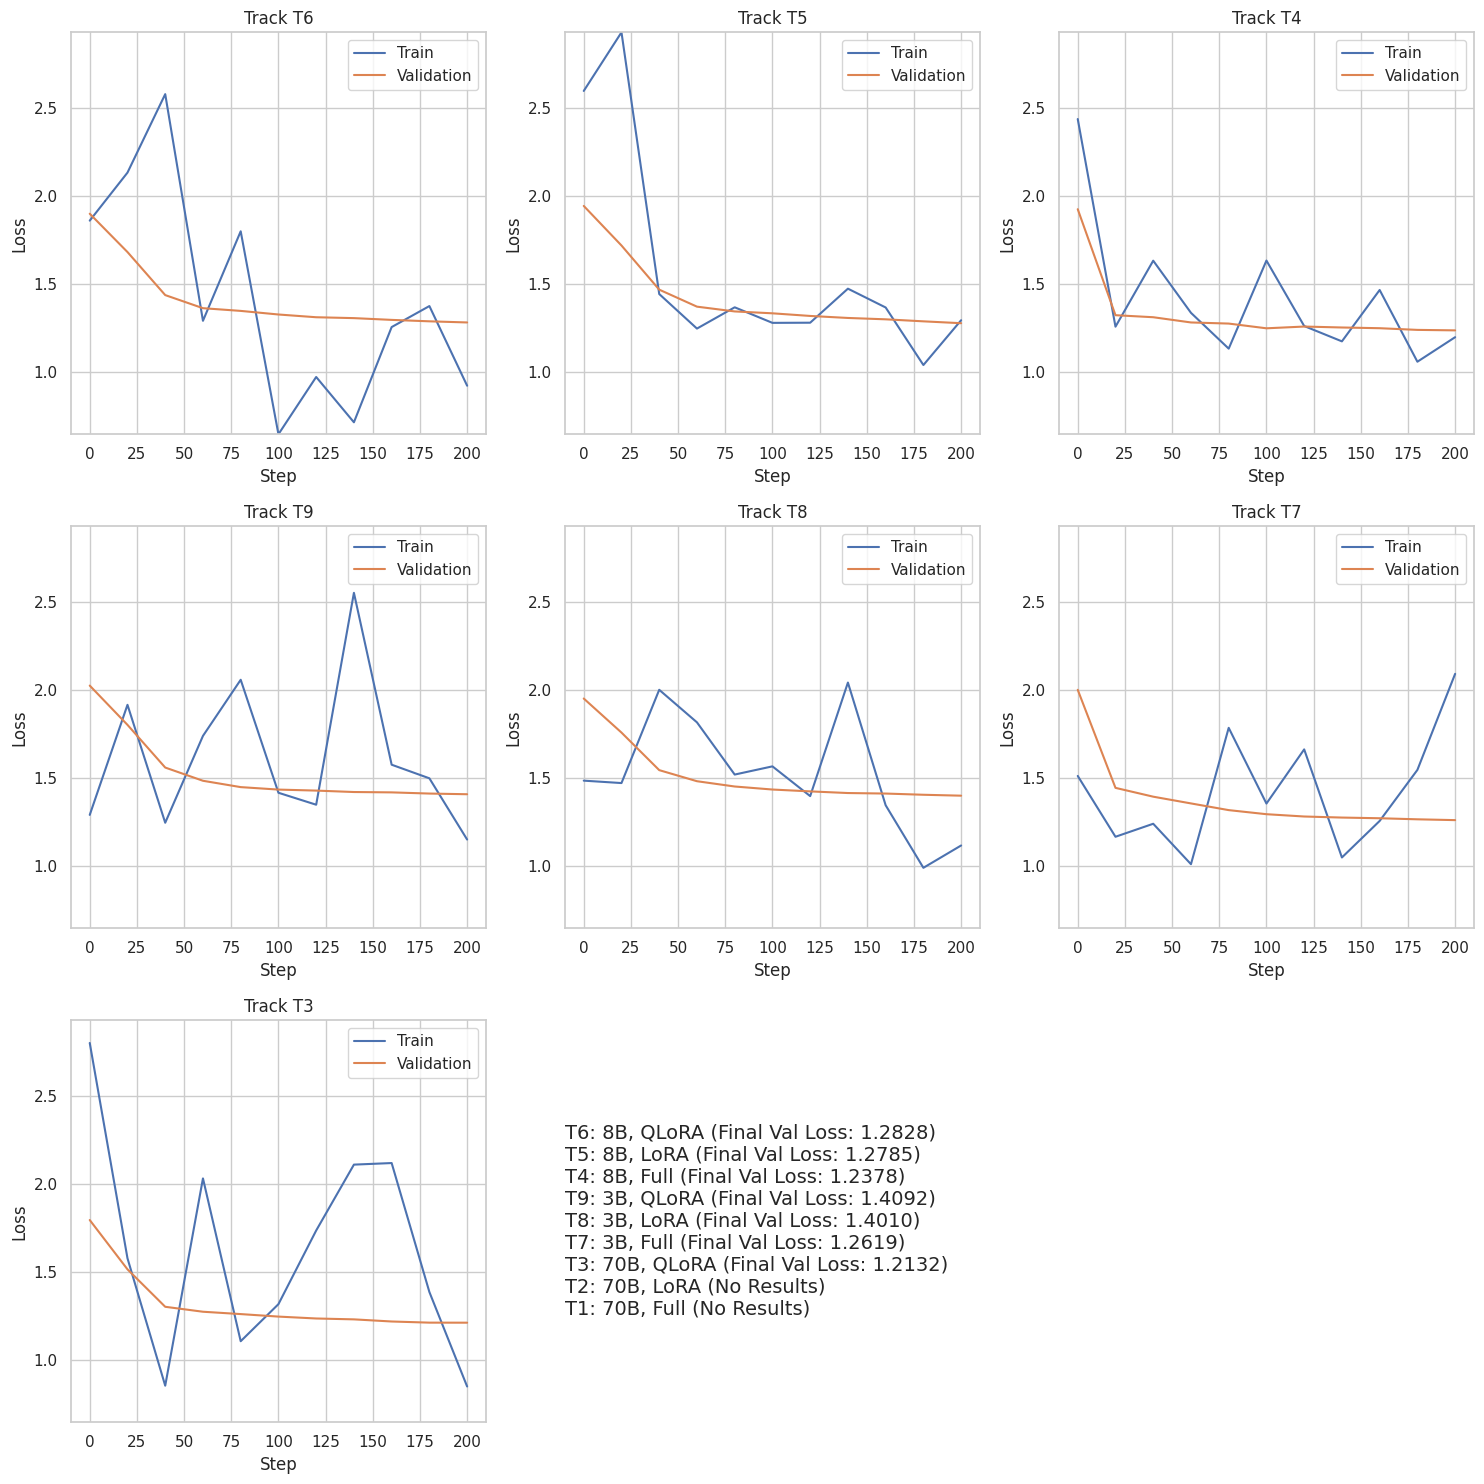

Final Validation Loss:
track_id
T3    1.213237
T4    1.237813
T5    1.278549
T6    1.282822
T7    1.261929
T8    1.400995
T9    1.409182
Name: loss, dtype: float64


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


history = pd.read_csv("partial_history.csv")
results = pd.read_csv("partial_results.csv")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

track_descriptions = {
    "T3": "70B, QLoRA",
    "T6": "8B, QLoRA",
    "T5": "8B, LoRA",
    "T9": "3B, QLoRA",
    "T8": "3B, LoRA",
    "T7": "3B, Full",
    "T2": "70B, LoRA",
    "T4": "8B, Full",
    "T1": "70B, Full"
}

ordered_tracks = ["T6", "T5", "T4", "T9", "T8", "T7", "T3", "T2", "T1"]

final_validation = history[history['type'] == 'Validation'].groupby('track_id')['loss'].last()

loss_min = history['loss'].min()
loss_max = history['loss'].max()

for i, track_id in enumerate(ordered_tracks):
    if track_id in history['track_id'].unique():
        track_data = history[history['track_id'] == track_id]
        ax = axes[i]
        for loss_type in ['Train', 'Validation']:
            subset = track_data[track_data['type'] == loss_type]
            ax.plot(subset['step'], subset['loss'], label=loss_type)
        ax.set_title(f'Track {track_id}')
        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.set_ylim(loss_min, loss_max)
        ax.legend()
        ax.grid(True)
    else:
        ax = axes[i]
        ax.axis('off')

for i in range(len(ordered_tracks), len(axes)):
    ax = axes[i]
    ax.axis('off')

key_ax = axes[-2]
key_ax.axis('off')
key_text = "\n".join([
    f"{track_id}: {track_descriptions[track_id]} (Final Val Loss: {final_validation[track_id]:.4f})"
    if track_id in final_validation else f"{track_id}: {track_descriptions[track_id]} (No Results)"
    for track_id in ordered_tracks
])
key_ax.text(0, 0.5, key_text, fontsize=14, va='center', ha='left', transform=key_ax.transAxes)

plt.tight_layout()
plt.show()

print("Final Validation Loss:")
print(final_validation)

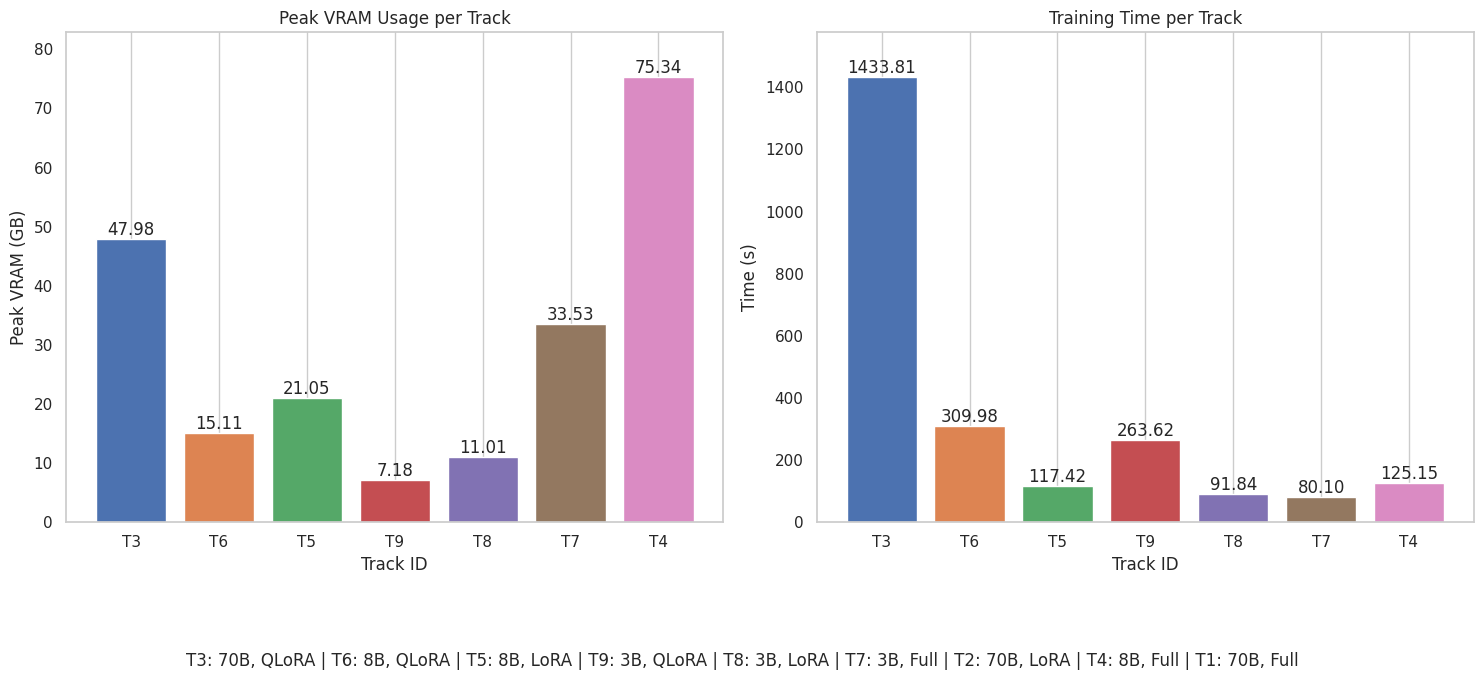

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

vram_max = results['peak_vram_gb'].max()
time_max = results['time'].max()

ax = axes[0]
for track_id in results['track_id'].unique():
    subset = results[results['track_id'] == track_id]
    mean_vram = subset['peak_vram_gb'].mean()
    ax.bar(track_id, mean_vram, label=f'Track {track_id}')
    ax.text(track_id, mean_vram, f'{mean_vram:.2f}', ha='center', va='bottom')
ax.set_title('Peak VRAM Usage per Track')
ax.set_xlabel('Track ID')
ax.set_ylabel('Peak VRAM (GB)')
ax.set_ylim(0, vram_max * 1.1)
ax.grid(axis='y')

ax = axes[1]
for track_id in results['track_id'].unique():
    subset = results[results['track_id'] == track_id]
    mean_time = subset['time'].mean()
    ax.bar(track_id, mean_time, label=f'Track {track_id}')
    ax.text(track_id, mean_time, f'{mean_time:.2f}', ha='center', va='bottom')
ax.set_title('Training Time per Track')
ax.set_xlabel('Track ID')
ax.set_ylabel('Time (s)')
ax.set_ylim(0, time_max * 1.1)
ax.grid(axis='y')

key_text = " | ".join([
    f"{track_id}: {track_descriptions[track_id]}"
    for track_id in track_descriptions
])
fig.text(0.5, -0.1, key_text, fontsize=12, ha='center', va='top')

plt.tight_layout()
plt.show()